# Setup

In [1]:
%load_ext autoreload
%autoreload 2
! pip install pycocoevalcap -q
! pip install evaluate -q
# ! pip install --upgrade transformers==4.46.3

# import gc
# torch.cuda.empty_cache()
# gc.collect()

import os
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms
from PIL import Image

from transformers import (
    VisionEncoderDecoderModel,
    # ViTImageProcessorFast,
    AutoImageProcessor,
    GPT2TokenizerFast,
)
import evaluate
import wandb

import nltk
from nltk.tokenize import word_tokenize
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

from tqdm import tqdm
from pathlib import Path
import sys

import os
from tqdm import tqdm
import evaluate

os.environ["TOKENIZERS_PARALLELISM"] = "false"  
notebook_dir = Path(os.getcwd()).resolve()  # Get the current working directory
project_root = notebook_dir.parents[1]  # Adjust the number to go up to the project root
sys.path.append(str(project_root))

print(f"Project root: {project_root}")

from data.dataset import FlickrDataset
from data.preprocessing import *
from metrics import calculate_metrics

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("wordnet")

_, _ = evaluate.load("bleu"), evaluate.load("meteor")

2024-12-06 14:28:46.360219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 14:28:46.360293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 14:28:46.361527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 14:28:46.368724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 14:28:47.221858: W tensorflow/compiler/tf2

Project root: /notebooks


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
dataset = "Flickr8k"
encoder_name = "google/vit-base-patch16-224-in21k" # Vision encoder model
decoder_name = "openai-community/gpt2"  # Text decoder model
model_name = "vit_gpt2"  # Vision encoder-decoder model

# Hyperparameters
config = {
    "encoder_name": encoder_name,  # Vision encoder model
    "decoder_name": decoder_name,  # Text decoder model
    "image_dir": f"../../flickr_data/{dataset}_Dataset/Images",  # Path to images
    "captions_file": f"../../flickr_data/{dataset}_Dataset/captions.txt",  # Path to captions
    "model_save_dir": f"{model_name}",  # Directory to save models
    "vocab_size": 5000,  # Maximum vocabulary size
    "embed_size": 256,  # Embedding size (optional if not using separate embeddings)
    "hidden_size": 512,  # Hidden size for decoder (not directly used with Hugging Face models)
    "batch_size": 32,  # Batch size
    "num_epochs": 10,  # Number of training epochs
    "learning_rate": 5e-5,  # Learning rate
    "weight_decay": 1e-4,  # Weight decay for optimizer
    "num_beams": 1,  # Number of beams for beam search, 1 means greedy search
    "seed": 42,  # Random seed for reproducibility
}


# Set random seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    # Some additional settings for full reproducibility (optional)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(config["seed"])

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data

Captions

In [3]:
# Load captions
caption_df = pd.read_csv(config["captions_file"]).dropna().drop_duplicates()
print(f"Total captions loaded: {len(caption_df)}")

# Build vocabulary
tokenizer = GPT2TokenizerFast.from_pretrained(config["decoder_name"])
# https://github.com/huggingface/transformers/issues/2630
# tokenizer.pad_token = (
#     tokenizer.eos_token
# )  # gpt2 does not have a pad token so we use eos token
# tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "<pad>"})

# special token mapping
# for gpt2 tokenizer
special_token_mapping = {
    "start": tokenizer.bos_token,
    "end": tokenizer.eos_token,
    "unk": tokenizer.unk_token,
    "pad": tokenizer.pad_token,
}

print(special_token_mapping)

word2idx, idx2word, image_captions = build_vocabulary(
    caption_df,
    vocab_size=10000,
    tokenizing_fn=lambda x: tokenizer.tokenize(x, add_special_tokens=False),
    special_tokens=list(set(special_token_mapping.values())),
)
word2idx_nltk, idx2word_nltk, image_captions_nltk = build_vocabulary(
    caption_df,
    vocab_size=10000,
    tokenizing_fn=word_tokenize,
)
print(f"Vocabulary size: {len(word2idx)}")
# set as vocab_size in config
config["vocab_size"] = len(word2idx)


def _convert_captions_to_sequences(
    image_captions, word2idx, special_token_mapping=None, tokenizing_fn=tokenize
):
    """
    Converts captions to sequences of word indices.
    Args:
        image_captions (dict): Mapping from image filenames to their captions.
        word2idx (dict): Mapping from words to indices.
    Returns:
        captions_seqs (dict): Mapping from image filenames to sequences of word indices.
        max_length (int): Maximum length of the captions.
    """
    captions_seqs = {}
    max_length = 0

    if not special_token_mapping:
        special_token_mapping = {
            "start": "<start>",
            "end": "<end>",
            "pad": "<pad>",
            "unk": "<unk>",
        }

    for img_name, captions in image_captions.items():
        seqs = []
        for caption in captions:
            # Tokenize and add start and end tokens
            tokens = (
                [special_token_mapping["start"]]
                + tokenizing_fn(caption)
                + [special_token_mapping["end"]]
            )
            # Convert tokens to indices based on gpt2 tokenizer
            seq = tokenizer.convert_tokens_to_ids(tokens)
            seqs.append(seq)
            # Update maximum caption length
            max_length = max(max_length, len(seq))
        captions_seqs[img_name] = seqs

    return captions_seqs, max_length


# Convert captions to sequences
captions_seqs, max_length = _convert_captions_to_sequences(
    image_captions,
    word2idx,
    special_token_mapping=special_token_mapping,
    tokenizing_fn=lambda x: tokenizer.tokenize(x, add_special_tokens=False),
)
captions_seqs_nltk, _ = convert_captions_to_sequences(
    image_captions_nltk,
    word2idx_nltk,
    tokenizing_fn=word_tokenize,
)
print(f"Maximum caption length: {max_length}")
# set as max_length in config
config["max_length"] = max_length

print(
    f"""
      Summary of special tokens replaced:
      <start>: {tokenizer.bos_token}
      <end>: {tokenizer.eos_token}
      <pad>: {tokenizer.pad_token}
      <unk>: {tokenizer.unk_token}
"""
)

print(
    f"""
    id of special tokens in vocab:
    <start>: {word2idx[tokenizer.bos_token]}
    <end>: {word2idx[tokenizer.eos_token]}
    <pad>: {word2idx[tokenizer.pad_token]}
    <unk>: {word2idx[tokenizer.unk_token]}
"""
)

print(
    f"""
    id of special tokens in tokenizer:
    <start>: {tokenizer.bos_token_id}
    <end>: {tokenizer.eos_token_id}
    <pad>: {tokenizer.pad_token_id}
    <unk>: {tokenizer.unk_token_id}
"""
)

print(
    f"""
    example sequences and captions:
    {list(image_captions.keys())[0]}
    {captions_seqs[list(image_captions.keys())[0]]}
    {list(image_captions.values())[0]}
"""
)

Total captions loaded: 40445
{'start': '<|endoftext|>', 'end': '<|endoftext|>', 'unk': '<|endoftext|>', 'pad': '<pad>'}
Vocabulary size: 8519
Maximum caption length: 43

      Summary of special tokens replaced:
      <start>: <|endoftext|>
      <end>: <|endoftext|>
      <pad>: <pad>
      <unk>: <|endoftext|>


    id of special tokens in vocab:
    <start>: 1
    <end>: 1
    <pad>: 0
    <unk>: 1


    id of special tokens in tokenizer:
    <start>: 50256
    <end>: 50256
    <pad>: 50257
    <unk>: 50256


    example sequences and captions:
    1000268201_693b08cb0e.jpg
    [[50256, 32, 1200, 287, 257, 11398, 6576, 318, 14281, 510, 257, 900, 286, 16046, 287, 281, 5726, 835, 764, 50256], [50256, 32, 2576, 1016, 656, 257, 13510, 2615, 764, 50256], [50256, 32, 1310, 2576, 14281, 656, 257, 13510, 711, 4803, 764, 50256], [50256, 32, 1310, 2576, 14281, 262, 16046, 284, 607, 711, 4803, 764, 50256], [50256, 32, 1310, 2576, 287, 257, 11398, 6576, 1016, 656, 257, 13510, 9351, 764, 50256]]

Images

In [4]:
# Get data transformations - slightly modified for ViT
processor = AutoImageProcessor.from_pretrained(config["encoder_name"])
# we'll keep processor for inference
print(f"vit mean: {processor.image_mean}, vit std: {processor.image_std}")

def get_transform(train=True):
    """
    Returns the image transformations for training or evaluation.
    Args:
        train (bool): Flag indicating whether transformations are for training or evaluation.
    Returns:
        transform (callable): Composed transformations.
    """
    if train:
        transform = transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=processor.image_mean, std=processor.image_std
                ),
            ]
        )
    else:
        transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=processor.image_mean, std=processor.image_std
                ),
            ]
        )
    return transform

train_transform = get_transform(train=True)
val_transform = get_transform(train=False)
# Split data into training and validation sets
image_names = list(image_captions.keys())
train_images, val_images, _ = get_splits(image_names, test_size=0.2)
print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")

vit mean: [0.5, 0.5, 0.5], vit std: [0.5, 0.5, 0.5]
Training samples: 6472
Validation samples: 1457


DataLoader

In [5]:
# modify the collate_fn
def collate_fn(batch):
    """
    Custom collate function to handle variable-length captions.
    This function pads captions to the length of the longest caption in the batch.
    Args:
        batch (list): List of tuples (image, caption_seq) or (image, caption_seq, image_id)
    Returns:
        If training:
            images (Tensor): Batch of images.
            targets (Tensor): Padded caption sequences.
            lengths (list): Original lengths of each caption before padding.
        If testing:
            images (Tensor): Batch of images.
            targets (Tensor): Padded caption sequences.
            image_ids (list): List of image filenames.
    """
    if len(batch[0]) == 3:
        # Test mode
        images, captions, image_ids = zip(*batch)
    else:
        # Train mode
        images, captions = zip(*batch)
        image_ids = None

    # Stack images
    images = torch.stack(images, 0)

    # Get lengths of each caption
    lengths = [len(cap) for cap in captions]

    # Pad captions to the length of the longest caption
    max_length = max(lengths)
    # targets = torch.zeros(len(captions), max_length).long()
    targets = torch.full((len(captions), max_length), tokenizer.pad_token_id).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end] # pad from the left

    if image_ids is not None:
        return images, targets, image_ids
    else:
        return images, targets, lengths

# Create datasets and data loaders
train_dataset = FlickrDataset(
    config["image_dir"],
    train_images,
    captions_seqs,
    transform=train_transform,
)
val_dataset = FlickrDataset(
    config["image_dir"], val_images, captions_seqs, transform=val_transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    # pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    # pin_memory=True,
)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Number of training batches: 1011
Number of validation batches: 228
Using device: cuda


In [6]:
# # get a batch to see what we have
# images, captions, lengths = next(iter(train_loader))
# print(images.shape, captions.shape, len(lengths))
# # print the captions
# print("captions:")
# print(captions)
# captions[captions == tokenizer.pad_token_id] = -100
# print(captions)

# Model

In [7]:
print(f"loading encoder: {encoder_name} and decoder: {decoder_name}...")
# Load the model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_name,
    decoder_name,
)

# slight modification for gpt2 tokenizer
# model.resize_token_embeddings(len(tokenizer))
model.decoder.resize_token_embeddings(len(tokenizer))
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.vocab_size = len(tokenizer) #config["vocab_size"]
model.config.beam_size = config["num_beams"]
model.config.max_length = config["max_length"]

model.to(device)

loading encoder: google/vit-base-patch16-224-in21k and decoder: openai-community/gpt2...


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['h.5.crossattention.q_attn.bias', 'h.10.crossattention.c_proj.weight', 'h.8.crossattention.c_proj.bias', 'h.4.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.2.crossattention.q_attn.weight', 'h.6.ln_cross_attn.weight', 'h.10.crossattention.c_attn.weight', 'h.0.crossattention.q_attn.bias', 'h.9.crossattention.c_proj.weight', 'h.1.crossattention.c_proj.weight', 'h.5.ln_cross_attn.bias', 'h.4.ln_cross_attn.bias', 'h.11.crossattention.c_attn.bias', 'h.5.ln_cross_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.4.crossattention.c_attn.weight', 'h.5.crossattention.c_attn.bias', 'h.9.ln_cross_attn.weight', 'h.2.ln_cross_attn.bias', 'h.6.crossattention.c_proj.bias', 'h.0.crossattention.q_attn.weight', 'h.0.crossattention.c_attn.weight', 'h.1.crossattention.c_attn.weight', 'h.7.crossattention.c_proj.weight', 'h.8.crossattention.c_attn.bias', '

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# Train

In [8]:
wandb.finish()
# wandb login
# wandb.login()
wandb.init(project="image-captioning")
wandb.config.update(config)

wandb: Currently logged in as: ivankohquanwei (ivan-koh). Use `wandb login --relogin` to force relogin


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f7b515db890>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f7b525d8490, execution_count=8 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f7b523680d0, raw_cell="wandb.finish()
# wandb login
# wandb.login()
wandb.." store_history=True silent=False shell_futures=True cell_id=49237fd9-2ed0-47a6-b03a-2c63299e0f68> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [9]:
# print(tokenizer.pad_token_id)
# print(tokenizer.bos_token_id)
# print(tokenizer.eos_token_id)
# print(tokenizer.unk_token_id)

# print("Decoder Configuration:")
# print(f"decoder_start_token_id: {model.config.decoder_start_token_id}")
# print(f"eos_token_id: {model.config.eos_token_id}")
# print(f"pad_token_id: {model.config.pad_token_id}")
# print(f"bos_token_id: {tokenizer.bos_token_id}")
# print(f"vocab_size: {model.config.vocab_size}")

# print(model.config.max_length)

# images, captions, lengths = next(iter(train_loader))
# images = images.to(device)
# captions = captions.to(device)
# tokenizer.decode(captions[0])
# captions[captions == tokenizer.pad_token_id] = -100



# model.eval()
# with torch.no_grad():
#     output = model.generate(
#         pixel_values=images,
#         max_length=50,
#         min_length=10,
#         num_beams=1,
#         do_sample=False,
#         early_stopping=True,
#         return_dict_in_generate=True,
#     )
#     # print(output)
#     pred = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
#     print("Predicted caption before training:", pred)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f7b515db890>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f7b5b0b30d0, raw_cell="# print(tokenizer.pad_token_id)
# print(tokenizer..." store_history=True silent=False shell_futures=True cell_id=207148e2-3b44-4866-b48c-97bad1683ddb>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f7b515db890>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f7b51e56c90, execution_count=9 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f7b5b0b30d0, raw_cell="# print(tokenizer.pad_token_id)
# print(tokenizer..." store_history=True silent=False shell_futures=True cell_id=207148e2-3b44-4866-b48c-97bad1683ddb> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [10]:
# % load_ext autoreload   
# % autoreload 2
# Initialize metrics storage
train_losses = []
val_losses = []
bleu_scores = []
meteor_scores = []
cider_scores = []

# Define optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"],
)

# Total training steps
num_epochs = config["num_epochs"]
total_steps = num_epochs * len(train_loader)

# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True,
)

# Prepare image to captions mapping for evaluation
val_image2captions = prepare_image2captions(val_images, captions_seqs_nltk, idx2word_nltk)

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (images, captions, _) in enumerate(pbar):
        # if i == 5: break # comment out later
        images = images.to(device)
        captions = captions.to(device)
        
        captions[captions == tokenizer.pad_token_id] = -100

        # Forward pass
        outputs = model(pixel_values=images, labels=captions)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()

        pbar.set_postfix({"loss": loss.item()})

    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc="Validation")
        for i, (images, captions, _) in enumerate(pbar_val):
            # if i == 5: break # comment out later
            images = images.to(device)
            captions = captions.to(device)
            
            captions[captions == tokenizer.pad_token_id] = -100

            outputs = model(pixel_values=images, labels=captions)
            loss = outputs.loss
            total_val_loss += loss.item()
            pbar_val.set_postfix({"val_loss": loss.item()})

    val_loss = total_val_loss / len(val_loader)  # average validation loss
    val_losses.append(val_loss)
    
    enable_wandb = True
    # Calculate evaluation metrics
    metrics = calculate_metrics(
        model=model,
        image_dir=config["image_dir"],
        image_ids=val_images,
        image2captions=val_image2captions,
        transform=val_transform,
        tokenizer=tokenizer,
        device=device,
        max_length=config["max_length"],
        verbose=True,
        enable_wandb=enable_wandb
    )
    bleu_scores.append(metrics["bleu"])
    meteor_scores.append(metrics["meteor"])
    cider_scores.append(metrics["cider"])
    

    log_data = {
    "epoch": epoch + 1,
    "train_loss": avg_train_loss,
    "val_loss": val_loss,
    "bleu": metrics["bleu"],
    "meteor": metrics["meteor"],
    "cider": metrics["cider"],
    }
    
    if enable_wandb:
        log_data[f"Sample Predictions/Epoch_{epoch + 1}"] = metrics["sample_table"]
    
    wandb.log(log_data)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Print epoch summary including new metrics
    epoch_duration = time.time() - start_time
    print(
        f"\nEpoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s"
        f"\nTraining Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        f"\nBLEU Score: {metrics['bleu']:.4f}, METEOR Score: {metrics['meteor']:.4f}, CIDEr Score: {metrics['cider']:.4f}\n"
    )

wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f7b515db890>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f7b5b0b2d10, raw_cell="# % load_ext autoreload   
# % autoreload 2
# Init.." store_history=True silent=False shell_futures=True cell_id=ce5dbd41-f2e7-4a21-8759-9ee40d742e69>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.94it/s, val_loss=2.3] 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..:   0%|          | 0/1457 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Eval Metrics..: 100%|██████████| 1457/1457 [04:40<00:00,  5.19it/s]
PTBTokeni

Sample Predictions:
Prediction: 
A man in a blue shirt is standing in front of a large building.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: ​A man in a blue shirt is driving a red car.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist', 'making', 'a', 'shar

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.94it/s, val_loss=2.34]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:44<00:00,  5.11it/s]
PTBTokenizer tokenized 92805 tokens at 615126.33 tokens per second.
PTBTokenizer tokenized 19464 tokens at 193644.87 tokens per second.


Sample Predictions:
Prediction: 

A man in a black shirt is standing in front of a large white wall.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: 

A man is driving a motorcycle on a dirt track.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist', 'making', 'a

Validation: 100%|██████████| 228/228 [00:58<00:00,  3.93it/s, val_loss=2.41]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:53<00:00,  4.97it/s]
PTBTokenizer tokenized 92805 tokens at 667711.21 tokens per second.
PTBTokenizer tokenized 21812 tokens at 209572.61 tokens per second.


Sample Predictions:
Prediction: , a man in a black shirt is standing in front of a building with a sign.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: , a man in a red shirt and a black jacket is riding a motorcycle.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorc

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.93it/s, val_loss=2.44]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:55<00:00,  4.93it/s]
PTBTokenizer tokenized 92805 tokens at 600194.29 tokens per second.
PTBTokenizer tokenized 22237 tokens at 187054.32 tokens per second.


Sample Predictions:
Prediction: , a man in a black shirt and jeans is standing on a sidewalk.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: , two children, and a dog are riding on a red and white vehicle.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist', 'ma

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.96it/s, val_loss=2.42]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:33<00:00,  5.33it/s]
PTBTokenizer tokenized 92805 tokens at 635296.56 tokens per second.
PTBTokenizer tokenized 20222 tokens at 195348.22 tokens per second.


Sample Predictions:
Prediction: , a man in a black shirt is standing on a ledge overlooking a city.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: , a group of people riding a motorbike.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist', 'making', 'a', 'sharp'

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.99it/s, val_loss=2.41]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:43<00:00,  5.14it/s]
PTBTokenizer tokenized 92805 tokens at 631356.66 tokens per second.
PTBTokenizer tokenized 20438 tokens at 199807.99 tokens per second.


Sample Predictions:
Prediction: , a woman in a black shirt and a man in a white shirt are standing in front of a brick building.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: , a group of people are riding bicycles on a track.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.97it/s, val_loss=2.6] 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:38<00:00,  5.24it/s]
PTBTokenizer tokenized 92805 tokens at 537089.98 tokens per second.
PTBTokenizer tokenized 19654 tokens at 174518.30 tokens per second.


Sample Predictions:
Prediction: A man in a red shirt is standing on a sidewalk with a sign advertising a free soda.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: The man is riding a motorcycle on a dirt track.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist'

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.98it/s, val_loss=2.49]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:59<00:00,  4.86it/s]
PTBTokenizer tokenized 92805 tokens at 556553.45 tokens per second.
PTBTokenizer tokenized 20093 tokens at 147596.47 tokens per second.


Sample Predictions:
Prediction: , a woman is standing in front of a window that says " HELL ".
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: , two black motorcycles racing around a track.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist', 'making', 'a', 'shar

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.95it/s, val_loss=2.55]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:25<00:00,  5.49it/s]
PTBTokenizer tokenized 92805 tokens at 599173.22 tokens per second.
PTBTokenizer tokenized 19554 tokens at 155225.59 tokens per second.


Sample Predictions:
Prediction: , a man in a black shirt is standing in front of a window.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: The man is riding a motorcycle on a dirt track.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist', 'making', 'a', 'sharp',

Validation: 100%|██████████| 228/228 [00:57<00:00,  3.95it/s, val_loss=2.64]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Eval Metrics..: 100%|██████████| 1457/1457 [04:16<00:00,  5.69it/s]
PTBTokenizer tokenized 92805 tokens at 635758.39 tokens per second.
PTBTokenizer tokenized 18655 tokens at 192510.24 tokens per second.


Sample Predictions:
Prediction: The man is standing on the deck of a boat.
References: [['a', 'man', 'inside', 'of', 'a', 'white', 'subway', 'train'], ['a', 'man', 'sits', 'by', 'a', 'window', 'on', 'a', 'train', '.'], ['a', 'man', 'sits', 'by', 'the', 'window', 'in', 'a', 'train', '.'], ['a', 'man', 'sits', 'in', 'the', 'window', 'of', 'a', 'train', '.'], ['the', 'side', 'of', 'a', 'subway', 'cart', ',', 'with', 'one', 'man', 'in', 'the', 'window', '.']]
--------------------------------------------------------------------------------
Prediction: The man is riding a motorcycle on a dirt track.
References: [['a', 'man', 'rides', 'a', 'motorcycle', 'on', 'a', 'track', '.'], ['a', 'motorcycle', 'racer', 'is', 'producing', 'sparks', 'by', 'leaning', 'during', 'a', 'turn', '.'], ['a', 'motorcyclist', 'is', 'turning', 'a', 'sharp', 'corner', 'on', 'his', 'red', 'motorbike', 'and', 'is', 'scraping', 'it', 'on', 'the', 'road', '.'], ['a', 'motorcyclist', 'making', 'a', 'sharp', 'turn', '.'], [

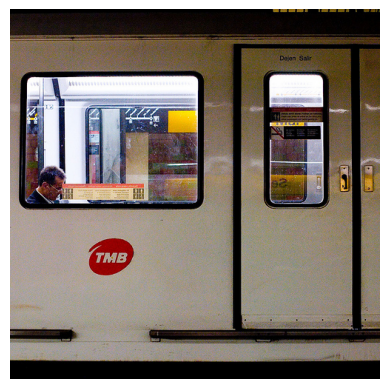

<|endoftext|>The man is standing on the deck of a boat.<|endoftext|>


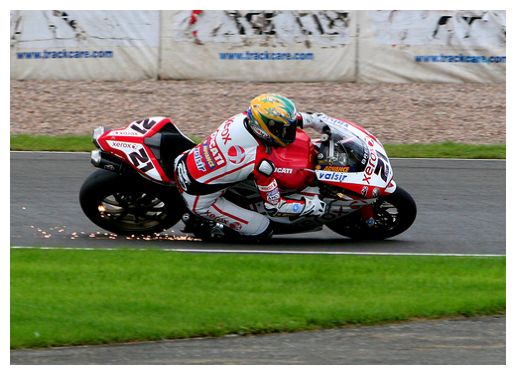

<|endoftext|>The man is riding a motorcycle on a dirt track.<|endoftext|>


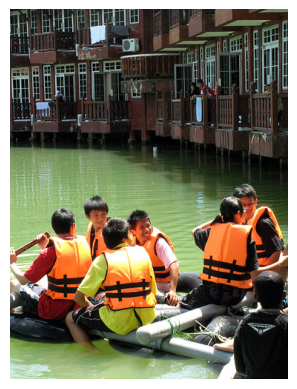

<|endoftext|>, a group of people playing soccer on a field<|endoftext|>


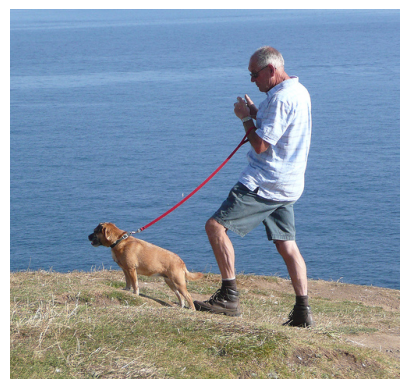

<|endoftext|>The man is walking a dog on a leash along a rocky beach.<|endoftext|>


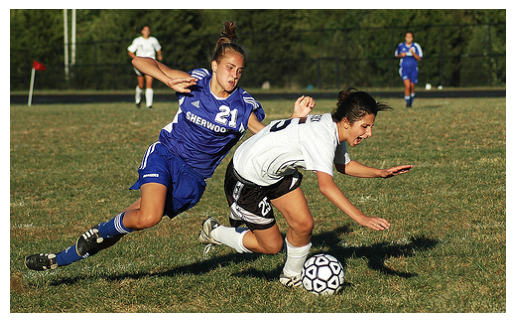

<|endoftext|>The boy in the blue and white jersey is running with the ball.<|endoftext|>


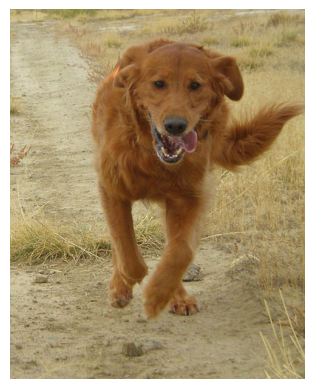

<|endoftext|>The brown dog is running on the sand.<|endoftext|>


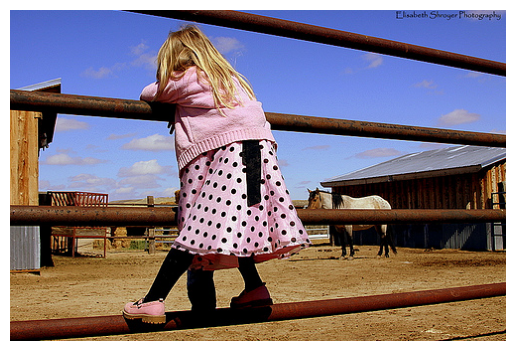

<|endoftext|>The boy is jumping over a rail. "<|endoftext|>


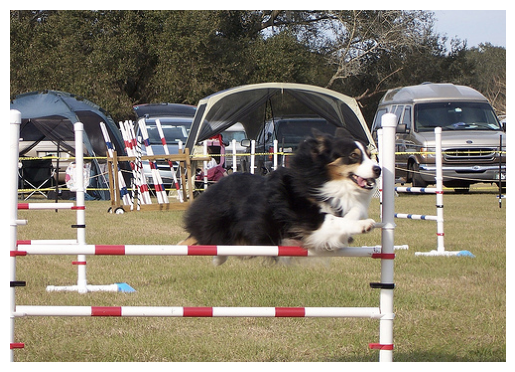

<|endoftext|>A black and white dog jumps over a bar in a competition.<|endoftext|>


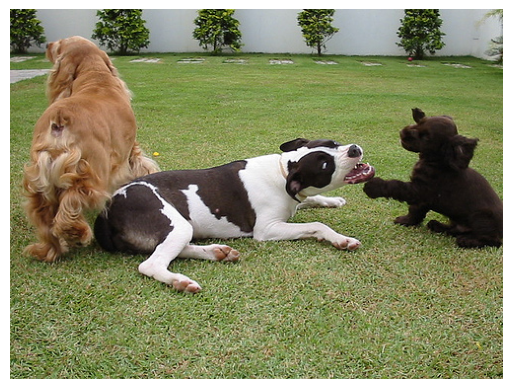

<|endoftext|>The two dogs are playing with a ball.<|endoftext|>


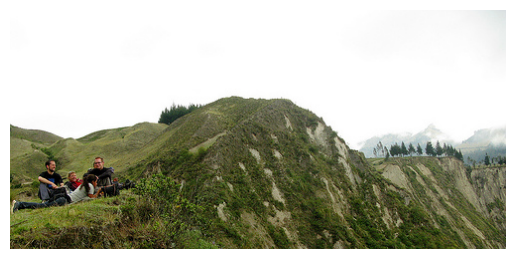

<|endoftext|>The man is hiking up a mountain. "<|endoftext|>


In [30]:
from PIL import Image
import matplotlib.pyplot as plt

for i in range(10):
    # Load and preprocess the image
    image_path = os.path.join(config["image_dir"], val_images[i])
    pil_image = Image.open(image_path).convert("RGB")

    # Show the image
    plt.imshow(pil_image)
    plt.axis("off")  # Hide axis for better display
    plt.show()

    pix = val_transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    print(
        tokenizer.decode(
            model.generate(
                pix,
                return_dict_in_generate=True,
                pad_token_id=tokenizer.pad_token_id,
                num_beams=1,
                do_sample=False,
                min_length=10,
                max_length=config["max_length"],
            ).sequences[0]
        )
    )

In [21]:
# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.savefig('./loss_plot.png')
plt.close()

# Plot evaluation metrics
plt.figure()
plt.plot(range(1, num_epochs + 1), bleu_scores, label='BLEU Score')
plt.plot(range(1, num_epochs + 1), meteor_scores, label='METEOR Score')
plt.plot(range(1, num_epochs + 1), cider_scores, label='CIDEr Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.savefig('./metrics_plot.png')
plt.close()

In [12]:
# simply save the model
model.save_pretrained(config['model_save_dir'])

Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
